# Collection & Cleaning (Citi Bike 2024)

Loads raw trips, builds a 30-minute grid representing citywide traffic, and explores trends


In [2]:
import pandas as pd 
import numpy as np
import time 
import glob
import re
from datetime import datetime
import dateutil 
import holidays
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Loading raw data into the notebook

csv_files = glob.glob("data/**/*.csv", recursive=True)
dfs_2024 = [pd.read_csv(file, low_memory = False) for  file in csv_files]
df = pd.concat(dfs_2024, ignore_index= True)


In [4]:
#Preliminary data exploration

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44303209 entries, 0 to 44303208
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 4.3+ GB


In [5]:
df.describe()

start_lat     start_lng       end_lat       end_lng
count  4.427337e+07  4.427337e+07  4.418090e+07  4.418090e+07
mean   4.073801e+01 -7.397144e+01  4.073770e+01 -7.397125e+01
std    4.088326e-02  2.900913e-02  9.159561e-02  1.516929e-01
min    4.063338e+01 -7.407196e+01  0.000000e+00 -7.408670e+01
25%    4.071311e+01 -7.399194e+01  4.071308e+01 -7.399203e+01
50%    4.073705e+01 -7.397907e+01  4.073653e+01 -7.397929e+01
75%    4.076144e+01 -7.395485e+01  4.076123e+01 -7.395487e+01
max    4.088630e+01 -7.384672e+01  4.088630e+01  0.000000e+00

# Cleaning Data and Separating Data into Arrivals and Departures per Station

In [6]:
#Ensuring all rides are of the same type

df['ride_id'] = df['ride_id'].astype(str).str.strip().str.lower()
df.head()

ride_id  rideable_type               started_at  \
0  c40e88bb937bdc15  electric_bike  2024-09-26 09:06:40.740   
1  f9db9fb8df1b9698  electric_bike  2024-09-15 16:36:01.749   
2  2c876366cd11d036  electric_bike  2024-09-24 22:44:19.582   
3  d639068ac8d3de4d   classic_bike  2024-09-16 16:39:05.447   
4  7c1b06cfc9849b71  electric_bike  2024-09-30 15:45:18.183   

                  ended_at           start_station_name start_station_id  \
0  2024-09-26 09:27:55.009      Columbia St & Degraw St          4422.04   
1  2024-09-15 16:50:41.891          Kent Ave & Grand St          5388.01   
2  2024-09-24 22:59:35.506           W 67 St & Broadway          7116.04   
3  2024-09-16 17:02:05.830        Madison Ave & E 82 St          7188.13   
4  2024-09-30 15:46:42.613  Lafayette Ave & St James Pl          4494.04   

                                end_station_name end_station_id  start_lat  \
0                               6 Ave & Canal St        5500.07  40.685930   
1                           Pike St & E Broadway        5270.05  40.716425   
2  Central Park North & Adam Clayton Powell Blvd        7617.07  40.774925   
3  Central Park North & Adam Clayton Powell Blvd        7617.07  40.778131   
4                       Willoughby Ave & Hall St        4611.03  40.688515   

   start_lng    end_lat    end_lng member_casual  
0 -74.002424  40.722438 -74.005664        casual  
1 -73.965940  40.714067 -73.992939        casual  
2 -73.982666  40.799484 -73.955613        casual  
3 -73.960694  40.799484 -73.955613        casual  
4 -73.964763  40.691960 -73.965369        casual

In [7]:
#Dropping duplicate rides

print(df['ride_id'][df['ride_id'].duplicated(keep=False)])
df['ride_id'].drop_duplicates()

Series([], Name: ride_id, dtype: object)


0           c40e88bb937bdc15
1           f9db9fb8df1b9698
2           2c876366cd11d036
3           d639068ac8d3de4d
4           7c1b06cfc9849b71
                  ...       
44303204    c049c1fb462707cd
44303205    d7102bd6283d129f
44303206    e548ac67537f0fe5
44303207    7f74fc8b7a9dd81a
44303208    4494283bfacb7e37
Name: ride_id, Length: 44303209, dtype: object

In [8]:
#Creating Dataframes for enters and exits

df_exits = df[['ride_id', 'started_at', 'start_station_name']].copy()
df_enter = df[['ride_id', 'ended_at', 'end_station_name']].copy()

In [9]:
#Fixing the dates in order to convert to datetime

exits_count = df_exits.shape[0]
enter_count = df_enter.shape[0]
print(f"before to datetime ride number for exits: {exits_count}" )
print(f"before to datetime ride number for arrival: {enter_count}" )

#STRIPPING THE TIMES TO CONVERT TO DATETIME

#Normalize & strip invisibles for exits
df_exits['started_at'] = (
    df_exits['started_at']
    .astype(str).str.strip()
    .str.replace('\u00A0', ' ', regex=False)
    .str.replace('\u200B', '',  regex=False)
)

#Crop anything past 19 chars
df_exits['started_at'] = df_exits['started_at'].str.replace(
    r'(^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}).*$', 
    r'\1', 
    regex=True
)
df_enter['ended_at'] = (
    df_enter['ended_at']
    .astype(str).str.strip()
    .str.replace('\u00A0', ' ', regex=False)
    .str.replace('\u200B', '',  regex=False)
    .str.replace(
        r'(^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}).*$', 
        r'\1', 
        regex=True
    )
)

#Parse with explicit format and convert dates to formal datetime index

df_exits['started_at'] = pd.to_datetime(
    df_exits['started_at'], 
    format='%Y-%m-%d %H:%M:%S', 
    errors='coerce'
)

df_enter['ended_at'] = pd.to_datetime(
    df_enter['ended_at'], 
    format='%Y-%m-%d %H:%M:%S', 
    errors='coerce'
)

print(f"after strip and datetime exits: {df_exits.shape[0]}")
print(f"after strip and datetime enter: {df_enter.shape[0]}")

#Verify that there aren't any NAT
print("Failed exits:", df_exits['started_at'].isna().sum())
print("Failed enters:", df_enter['ended_at'].isna().sum())

before to datetime ride number for exits: 44303209
before to datetime ride number for arrival: 44303209
after strip and datetime exits: 44303209
after strip and datetime enter: 44303209
Failed exits: 0
Failed enters: 0


In [10]:
# DROPS NAT IF IT EXISTS AND SETS DATETIME INDEX
df_exits = df_exits.dropna(subset=['started_at'])
df_enter = df_enter.dropna(subset=['ended_at'])

df_exits = df_exits.set_index('started_at')
df_enter = df_enter.set_index('ended_at')

In [11]:
#Printing and dropping NAN values in both departure and arrival dataframes

print(f"count for NAN values in start station names: {df_exits['start_station_name'].isna().sum()}")
print(f"count for NAN values in end station names: {df_enter['end_station_name'].isna().sum()}")

df_exits = df_exits.dropna(subset='start_station_name')
df_enter = df_enter.dropna(subset='end_station_name')

count for NAN values in start station names: 29835
count for NAN values in end station names: 114545


In [12]:
# DROP ANY RIDES THAT AREN'T PRESENT IN BOTH DATAFRAMES

df_exits = df_exits[df_exits['ride_id'].isin(df_enter['ride_id'])]
df_enter = df_enter[df_enter['ride_id'].isin(df_exits['ride_id'])]

print(df_exits.shape[0])
print(df_enter.shape[0])

44173378
44173378


In [13]:
#Grouping data by stations to show number of rides per station at each time

print(f"number of rows without station name exits: {df_exits['start_station_name'].isna().sum()}")
print(f"number of rows without station name enter: {df_enter['end_station_name'].isna().sum()}")

df_exits = df_exits.groupby('start_station_name').resample('30min')['ride_id'].count()
df_enter = df_enter.groupby('end_station_name').resample('30min')['ride_id'].count()


print(f"after resampling and grouping by stations exits: {df_exits.shape[0]}")
print(f"after resampling and grouping by stations enter: {df_enter.shape[0]}")

number of rows without station name exits: 0
number of rows without station name enter: 0
after resampling and grouping by stations exits: 37558550
after resampling and grouping by stations enter: 38437665


In [14]:
df_exits.head(10000)

start_station_name  started_at         
1 Ave & E 110 St    2024-01-01 06:00:00    1
                    2024-01-01 06:30:00    1
                    2024-01-01 07:00:00    0
                    2024-01-01 07:30:00    0
                    2024-01-01 08:00:00    0
                                          ..
                    2024-07-27 11:30:00    3
                    2024-07-27 12:00:00    2
                    2024-07-27 12:30:00    0
                    2024-07-27 13:00:00    2
                    2024-07-27 13:30:00    4
Name: ride_id, Length: 10000, dtype: int64

In [15]:
df_enter.head(10000)

end_station_name  ended_at           
1 Ave & E 110 St  2024-01-01 00:30:00    2
                  2024-01-01 01:00:00    1
                  2024-01-01 01:30:00    0
                  2024-01-01 02:00:00    0
                  2024-01-01 02:30:00    0
                                        ..
                  2024-07-27 06:00:00    0
                  2024-07-27 06:30:00    2
                  2024-07-27 07:00:00    0
                  2024-07-27 07:30:00    0
                  2024-07-27 08:00:00    0
Name: ride_id, Length: 10000, dtype: int64

In [16]:
#Unstacking dataframe making stations as columns so it is easier to analyze

df_exits_final = df_exits.unstack(level='start_station_name', fill_value=0)
df_exits_final.head(30)

start_station_name   1 Ave & E 110 St  1 Ave & E 118 St  1 Ave & E 16 St  \
started_at                                                                 
2023-12-31 13:30:00                 0                 0                0   
2023-12-31 14:00:00                 0                 0                0   
2023-12-31 14:30:00                 0                 0                0   
2023-12-31 15:00:00                 0                 0                0   
2023-12-31 15:30:00                 0                 0                0   
2023-12-31 16:00:00                 0                 0                0   
2023-12-31 16:30:00                 0                 0                0   
2023-12-31 17:00:00                 0                 0                0   
2023-12-31 17:30:00                 0                 0                0   
2023-12-31 18:00:00                 0                 0                0   
2023-12-31 18:30:00                 0                 0                0   
2023-12-31 19:00:00                 0                 0                0   
2023-12-31 19:30:00                 0                 0                0   
2023-12-31 20:00:00                 0                 0                0   
2023-12-31 20:30:00                 0                 0                0   
2023-12-31 21:00:00                 0                 0                0   
2023-12-31 21:30:00                 0                 0                0   
2023-12-31 22:00:00                 0                 0                0   
2023-12-31 22:30:00                 0                 0                0   
2023-12-31 23:00:00                 0                 0                0   
2023-12-31 23:30:00                 0                 0                1   
2024-01-01 00:00:00                 0                 0                0   
2024-01-01 00:30:00                 0                 0                3   
2024-01-01 01:00:00                 0                 0                4   
2024-01-01 01:30:00                 0                 0                2   
2024-01-01 02:00:00                 0                 0                2   
2024-01-01 02:30:00                 0                 0                1   
2024-01-01 03:00:00                 0                 0                2   
2024-01-01 03:30:00                 0                 0                2   
2024-01-01 04:00:00                 0                 0                3   

start_station_name   1 Ave & E 18 St  1 Ave & E 30 St  1 Ave & E 38 St  \
started_at                                                               
2023-12-31 13:30:00                0                0                0   
2023-12-31 14:00:00                0                0                0   
2023-12-31 14:30:00                0                0                0   
2023-12-31 15:00:00                0                0                0   
2023-12-31 15:30:00                0                0                0   
2023-12-31 16:00:00                0                0                0   
2023-12-31 16:30:00                0                0                0   
2023-12-31 17:00:00                0                0                0   
2023-12-31 17:30:00                0                0                0   
2023-12-31 18:00:00                0                0                0   
2023-12-31 18:30:00                0                0                0   
2023-12-31 19:00:00                0                0                0   
2023-12-31 19:30:00                0                0                0   
2023-12-31 20:00:00                0                0                0   
2023-12-31 20:30:00                0                0                0   
2023-12-31 21:00:00                0                0                0   
2023-12-31 21:30:00                0                0                0   
2023-12-31 22:00:00                0                0                0   
2023-12-31 22:30:00                0                0                0   
2023-12-31 23

In [17]:
#Unstacking dataframe making stations as columns so it is easier to analyze

df_enter_final = df_enter.unstack(level='end_station_name', fill_value=0)
df_enter_final.head(30)

end_station_name     1 Ave & E 110 St  1 Ave & E 118 St  1 Ave & E 16 St  \
ended_at                                                                   
2024-01-01 00:00:00                 0                 0                0   
2024-01-01 00:30:00                 2                 0                2   
2024-01-01 01:00:00                 1                 0                0   
2024-01-01 01:30:00                 0                 0                2   
2024-01-01 02:00:00                 0                 0                1   
2024-01-01 02:30:00                 0                 0                2   
2024-01-01 03:00:00                 1                 0                0   
2024-01-01 03:30:00                 1                 0                0   
2024-01-01 04:00:00                 1                 0                2   
2024-01-01 04:30:00                 0                 0                1   
2024-01-01 05:00:00                 0                 0                1   
2024-01-01 05:30:00                 1                 0                0   
2024-01-01 06:00:00                 0                 0                1   
2024-01-01 06:30:00                 0                 0                1   
2024-01-01 07:00:00                 0                 0                0   
2024-01-01 07:30:00                 0                 0                0   
2024-01-01 08:00:00                 0                 0                0   
2024-01-01 08:30:00                 0                 0                0   
2024-01-01 09:00:00                 0                 0                0   
2024-01-01 09:30:00                 0                 0                1   
2024-01-01 10:00:00                 0                 0                0   
2024-01-01 10:30:00                 1                 0                0   
2024-01-01 11:00:00                 0                 0                2   
2024-01-01 11:30:00                 0                 0                1   
2024-01-01 12:00:00                 1                 0                1   
2024-01-01 12:30:00                 1                 0                4   
2024-01-01 13:00:00                 0                 0                3   
2024-01-01 13:30:00                 2                 0                2   
2024-01-01 14:00:00                 0                 0                4   
2024-01-01 14:30:00                 0                 0                2   

end_station_name     1 Ave & E 18 St  1 Ave & E 30 St  1 Ave & E 38 St  \
ended_at                                                                 
2024-01-01 00:00:00                0                0                0   
2024-01-01 00:30:00                2                2                0   
2024-01-01 01:00:00                3                1                0   
2024-01-01 01:30:00                0                1                0   
2024-01-01 02:00:00                3                3                0   
2024-01-01 02:30:00                3                0                0   
2024-01-01 03:00:00                2                2                0   
2024-01-01 03:30:00                1                2                0   
2024-01-01 04:00:00                0                1                0   
2024-01-01 04:30:00                0                0                0   
2024-01-01 05:00:00                1                0                0   
2024-01-01 05:30:00                1                1                0   
2024-01-01 06:00:00                0                0                0   
2024-01-01 06:30:00                0                9                0   
2024-01-01 07:00:00                0                2                0   
2024-01-01 07:30:00                0                3                0   
2024-01-01 08:00:00                0                3                0   
2024-01-01 08:30:00                0                0                0   
2024-01-01 09:00:00                1                0                0   
2024-01-01 09

Creating Net Traffic Dataframe showing the net traffic at each station for each 30 minute interval

In [18]:
#Combining the dataframes ot calculate net traffic 

net_traffic_df = df_enter_final.sub(df_exits_final, fill_value=0)

#Sanity checking making sure each ride is accounted for once

print(df_enter_final.sum().sum() - df_exits_final.sum().sum())
print(net_traffic_df.sum().sum())

#Making sure that the dataframe's datetime index is based on the year 2024

net_traffic_df = net_traffic_df[net_traffic_df.index.year == 2024]


0
0.0


In [19]:
#Sanity checking net traffic dataframe
print(net_traffic_df.shape[0])
net_traffic_df.head(30)

17568


1 Ave & E 110 St  1 Ave & E 118 St  1 Ave & E 16 St  \
2024-01-01 00:00:00               0.0               0.0              0.0   
2024-01-01 00:30:00               2.0               0.0             -1.0   
2024-01-01 01:00:00               1.0               0.0             -4.0   
2024-01-01 01:30:00               0.0               0.0              0.0   
2024-01-01 02:00:00               0.0               0.0             -1.0   
2024-01-01 02:30:00               0.0               0.0              1.0   
2024-01-01 03:00:00               1.0               0.0             -2.0   
2024-01-01 03:30:00               1.0               0.0             -2.0   
2024-01-01 04:00:00               1.0               0.0             -1.0   
2024-01-01 04:30:00               0.0               0.0              1.0   
2024-01-01 05:00:00               0.0               0.0              1.0   
2024-01-01 05:30:00               1.0               0.0              0.0   
2024-01-01 06:00:00              -1.0               0.0              1.0   
2024-01-01 06:30:00              -1.0               0.0              1.0   
2024-01-01 07:00:00               0.0               0.0              0.0   
2024-01-01 07:30:00               0.0               0.0              0.0   
2024-01-01 08:00:00               0.0               0.0              0.0   
2024-01-01 08:30:00              -1.0               0.0              0.0   
2024-01-01 09:00:00               0.0               0.0             -1.0   
2024-01-01 09:30:00              -1.0               0.0              0.0   
2024-01-01 10:00:00               0.0               0.0             -1.0   
2024-01-01 10:30:00               1.0               0.0              0.0   
2024-01-01 11:00:00              -1.0               0.0             -1.0   
2024-01-01 11:30:00               0.0               0.0             -1.0   
2024-01-01 12:00:00               0.0               0.0             -2.0   
2024-01-01 12:30:00               0.0               0.0              4.0   
2024-01-01 13:00:00              -3.0               0.0              1.0   
2024-01-01 13:30:00               2.0               0.0              1.0   
2024-01-01 14:00:00               0.0               0.0              2.0   
2024-01-01 14:30:00               0.0               0.0              2.0   

                     1 Ave & E 18 St  1 Ave & E 30 St  1 Ave & E 38 St  \
2024-01-01 00:00:00              0.0             -5.0              0.0   
2024-01-01 00:30:00              1.0              2.0              0.0   
2024-01-01 01:00:00              3.0              0.0              0.0   
2024-01-01 01:30:00              0.0              0.0              0.0   
2024-01-01 02:00:00              3.0              2.0              0.0   
2024-01-01 02:30:00              1.0              0.0              0.0   
2024-01-01 03:00:00              1.0              2.0              0.0   
2024-01-01 03:30:00              1.0              1.0              0.0   
2024-01-01 04:00:00              0.0              0.0              0.0   
2024-01-01 04:30:00              0.0              0.0              0.0   
2024-01-01 05:00:00              0.0              0.0              0.0   
2024-01-01 05:30:00              0.0              1.0              0.0   
2024-01-01 06:00:00              0.0             -1.0              0.0   
2024-01-01 06:30:00              0.0              9.0              0.0   
2024-01-01 07:00:00              0.0              0.0              0.0   
2024-01-01 07:30:00              0.0              2.0              0.0   
2024-01-01 08:00:00              0.0              2.0              0.0   
2024-01-01 08:30:00             -1.0             -1.0              0.0   
2024-01-01 09:00:00             -1.0              0.0              0.0   
2024-01-01 09:30:00             -3.0              1.0              0.0   
2024-01-01 10:00:00              0.0              0.0              0.0   
2024-01-01 10:30:00              0.0

# Adding more features to dataframes

WEATHER

In [21]:
#Importing weather features
from meteostat import Hourly, Point

# Central Park coordinates
cp = Point(40.7812, -73.9665)

start = datetime(2024, 1, 1, 0)
end   = datetime(2025, 1, 1, 0)

# Fetch hourly data
weather_df = Hourly(cp, start, end).fetch()
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8785 entries, 2024-01-01 00:00:00 to 2025-01-01 00:00:00
Freq: h
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    8785 non-null   Float64
 1   dwpt    8785 non-null   Float64
 2   rhum    8785 non-null   Float64
 3   prcp    8774 non-null   Float64
 4   snow    0 non-null      Float64
 5   wdir    8785 non-null   Float64
 6   wspd    8785 non-null   Float64
 7   wpgt    0 non-null      Float64
 8   pres    8785 non-null   Float64
 9   tsun    0 non-null      Float64
 10  coco    8779 non-null   Float64
dtypes: Float64(11)
memory usage: 918.0 KB


In [22]:
# Rename and slice columns while keeping temp, precipitation, and wind speed. Also creates boolean column to check if raining

weather_df = (
    weather_df.rename(columns={
        "temp": "temp_c",        # °C
        "prcp": "precip_mm",     # mm
        "wspd": "wind_speed",      # km/h
    })[["temp_c", "precip_mm", "wind_speed"]].copy()
)

precip_col = weather_df.precip_mm.resample('30min').ffill() / 2

temp_col = weather_df.temp_c.resample('30min').interpolate('time')

wind_col = weather_df.wind_speed.resample('30min').ffill()

weather_df = pd.concat([precip_col, temp_col, wind_col], axis=1)

weather_df["is_raining"] = (weather_df["precip_mm"].fillna(0) > 0).astype(int)

weather_df = weather_df.loc["2024-01-01":"2024-12-31 23:30"]

weather_df['temp_f'] = weather_df['temp_c'] * 9/5 + 32

weather_df.drop('temp_c', axis=1, inplace=True)

# Save clean CSV (index is the timestamp)
print(weather_df.shape[0])

17568


DATES (Holidays, Weekend, Day of Week, Month, Season)

In [23]:
#Creating 'dates' column that represents US National Holidays 

dates = pd.date_range('2024-01-01 00:00', '2024-12-31 23:30', freq="30min")
dates_df = dates.to_series().dt.date.isin(holidays.US(years=2024))
dates_df.shape[0]

17568

In [24]:
#Adding is_weekend column to show if day is weekend or not

is_weekend_col = pd.Series(net_traffic_df.index.dayofweek >= 5, index=net_traffic_df.index, name= 'is_weekend')
day_col = pd.Series(net_traffic_df.index.dayofweek, index=net_traffic_df.index, name='day of week')
month_col = pd.Series(net_traffic_df.index.month, index=net_traffic_df.index, name='month')
print(is_weekend_col.shape[0])
print(day_col.shape[0])
print(month_col.shape[0])

17568
17568
17568


In [25]:
# #Adding Day of Week and Month 

days_dates_df = pd.concat([is_weekend_col, day_col, month_col], axis=1)
print(f"days and dates len: {days_dates_df.shape[0]}")
print(f"weather len: {weather_df.shape[0]}")
print(f"holidays len: {dates_df.shape[0]}")

days and dates len: 17568
weather len: 17568
holidays len: 17568


In [26]:
#Joining weather and national holiday mask to traffic dataframe

dates_df.name = 'holidays'
final_df = net_traffic_df.join(weather_df, how='left').join(dates_df, how='left').join(days_dates_df, how='left')

In [27]:
#Checking if same length as traffic dataframe and also ensuring there is no NANs

print(final_df['holidays'].isna().sum())

0


In [28]:
#Sanity check ensuring the number of entries for holidays dates are correct
final_df[final_df['holidays'] == True].shape[0]

528

In [29]:
#Creating function that maps the date to a corresponding season in order to see seasonality features

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
season_col = pd.Series([get_season(m) for m in final_df.index.month], index= final_df.index, name='season')
final_df = final_df.join(season_col, how='left')

In [30]:
print(net_traffic_df.shape[0])

17568


SANITY CHECKS

In [31]:
final_df.to_csv('dataframe_final.csv')

In [32]:
final_df.iloc[:, :-9].stack().describe()


count    4.028342e+07
mean     9.035975e-06
std      1.773077e+00
min     -7.600000e+01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      6.700000e+01
dtype: float64

In [33]:
final_df.iloc[:, :-7].sum(axis=1).describe()


count       17568.0
mean      11.062938
std      209.855705
min         -1954.4
25%           -80.0
50%            16.0
75%            96.0
max         2036.15
dtype: Float64

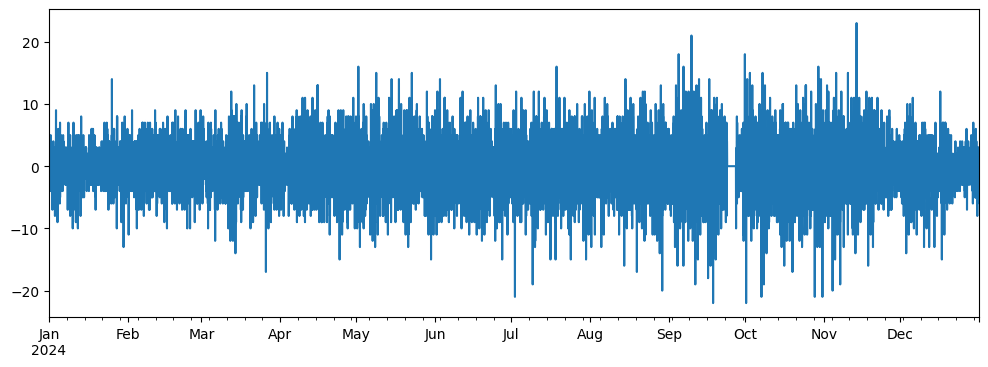

In [34]:
final_df['1 Ave & E 16 St'].plot(figsize=(12,4))
plt.show()

In [35]:
final_df.head()


1 Ave & E 110 St  1 Ave & E 118 St  1 Ave & E 16 St  \
2024-01-01 00:00:00               0.0               0.0              0.0   
2024-01-01 00:30:00               2.0               0.0             -1.0   
2024-01-01 01:00:00               1.0               0.0             -4.0   
2024-01-01 01:30:00               0.0               0.0              0.0   
2024-01-01 02:00:00               0.0               0.0             -1.0   

                     1 Ave & E 18 St  1 Ave & E 30 St  1 Ave & E 38 St  \
2024-01-01 00:00:00              0.0             -5.0              0.0   
2024-01-01 00:30:00              1.0              2.0              0.0   
2024-01-01 01:00:00              3.0              0.0              0.0   
2024-01-01 01:30:00              0.0              0.0              0.0   
2024-01-01 02:00:00              3.0              2.0              0.0   

                     1 Ave & E 39 St  1 Ave & E 42 St  1 Ave & E 44 St  \
2024-01-01 00:00:00              2.0              0.0              0.0   
2024-01-01 00:30:00              5.0              0.0             -1.0   
2024-01-01 01:00:00              1.0              0.0              0.0   
2024-01-01 01:30:00              0.0              0.0              0.0   
2024-01-01 02:00:00              1.0              0.0              0.0   

                     1 Ave & E 6 St  ...  York St & Marin Blvd  precip_mm  \
2024-01-01 00:00:00            -1.0  ...                   0.0        0.0   
2024-01-01 00:30:00             3.0  ...                   0.0        0.0   
2024-01-01 01:00:00             5.0  ...                   0.0        0.0   
2024-01-01 01:30:00             0.0  ...                   0.0        0.0   
2024-01-01 02:00:00             0.0  ...                   0.0        0.0   

                     wind_speed  is_raining  temp_f  holidays  is_weekend  \
2024-01-01 00:00:00        11.0           0    42.8      True       False   
2024-01-01 00:30:00        11.0           0    42.8      True       False   
2024-01-01 01:00:00         7.9           0    42.8      True       False   
2024-01-01 01:30:00         7.9           0    42.8      True       False   
2024-01-01 02:00:00         6.0           0    42.8      True       False   

                     day of week  month  season  
2024-01-01 00:00:00            0      1  Winter  
2024-01-01 00:30:00            0      1  Winter  
2024-01-01 01:00:00            0      1  Winter  
2024-01-01 01:30:00            0      1  Winter  
2024-01-01 02:00:00            0      1  Winter  

[5 rows x 2302 columns]

Creating a dataframe that represents TOTAL traffic at each station per 30 minute interval

In [36]:
total_traffic_df = df_enter_final.add(df_exits_final, fill_value=0)
total_traffic_df = total_traffic_df[total_traffic_df.index.year == 2024]

#Creating a dataframe that represents the statistics for each station

station_stats = pd.DataFrame({
    'station': total_traffic_df.columns,
    'avg_rides_30min': total_traffic_df.mean(),
    'variance': total_traffic_df.var(),
    'total_rides': total_traffic_df.sum()
}).reset_index(drop=True)

# Mapping each station to a corresponding neighborhood and borough based on latitude and longitude

In [37]:
#Getting station latitude and longitude coordinates from raw data

stations_cord_df = df[['start_station_name', 'start_lat', 'start_lng']].drop_duplicates().reset_index(drop=True)
stations_cord_df = stations_cord_df.rename(columns={
    'start_station_name': 'station',
    'start_lat': 'lat',
    'start_lng': 'lon'
})

print(stations_cord_df.head())
print(stations_cord_df.shape[0])

                       station        lat        lon
0      Columbia St & Degraw St  40.685930 -74.002424
1          Kent Ave & Grand St  40.716425 -73.965940
2           W 67 St & Broadway  40.774925 -73.982666
3        Madison Ave & E 82 St  40.778131 -73.960694
4  Lafayette Ave & St James Pl  40.688515 -73.964763
2303


In [38]:
import geopandas as gpd
from shapely.geometry import Point

#Importing NTA (Neighborhood Tribulation Areas) data 

NTA = gpd.read_file('Neighborhood_NTA.geojson')
NTA = NTA[["nta2020","ntaname","boroname","geometry"]]
NTA = NTA.rename(columns={"nta2020": "NTA2020", "ntaname": "NTAName", "boroname": "BoroName"})


# Build station GeoDataFrame
stations_gdf = gpd.GeoDataFrame(
    stations_cord_df.copy(), 
    geometry=gpd.points_from_xy(stations_cord_df["lon"], stations_cord_df["lat"]),
    crs="EPSG:4326"
)

# Ensure CRS match
NTA = NTA.set_crs("EPSG:4326") if NTA.crs is None else NTA.to_crs("EPSG:4326")

# Spatial join: assign each station to an NTA
stations_with_nta = gpd.sjoin(
    stations_gdf,
    NTA[["NTA2020", "NTAName", "BoroName", "geometry"]],
    how="left",
    predicate="intersects"
)
# Clean result
stations_with_nta = stations_with_nta[["station", "lat", "lon", "NTA2020", "NTAName", "BoroName"]]
stations_with_nta = stations_with_nta.drop_duplicates(subset='station')






In [39]:
print(NTA.columns)

Index(['NTA2020', 'NTAName', 'BoroName', 'geometry'], dtype='object')


In [40]:
print(stations_with_nta[stations_with_nta.isna()])

     station  lat  lon NTA2020 NTAName BoroName
0        NaN  NaN  NaN     NaN     NaN      NaN
1        NaN  NaN  NaN     NaN     NaN      NaN
2        NaN  NaN  NaN     NaN     NaN      NaN
3        NaN  NaN  NaN     NaN     NaN      NaN
4        NaN  NaN  NaN     NaN     NaN      NaN
...      ...  ...  ...     ...     ...      ...
2298     NaN  NaN  NaN     NaN     NaN      NaN
2299     NaN  NaN  NaN     NaN     NaN      NaN
2300     NaN  NaN  NaN     NaN     NaN      NaN
2301     NaN  NaN  NaN     NaN     NaN      NaN
2302     NaN  NaN  NaN     NaN     NaN      NaN

[2274 rows x 6 columns]


In [41]:
#Combining station statistics along with neighborhood and borough data

station_stats = station_stats.merge(
    stations_with_nta[["station", "NTAName", "BoroName"]],
    on="station",
    how="left"
)


In [42]:
print(station_stats[station_stats.isna()])
print(station_stats)


     station  avg_rides_30min  variance  total_rides NTAName BoroName
0        NaN              NaN       NaN          NaN     NaN      NaN
1        NaN              NaN       NaN          NaN     NaN      NaN
2        NaN              NaN       NaN          NaN     NaN      NaN
3        NaN              NaN       NaN          NaN     NaN      NaN
4        NaN              NaN       NaN          NaN     NaN      NaN
...      ...              ...       ...          ...     ...      ...
2288     NaN              NaN       NaN          NaN     NaN      NaN
2289     NaN              NaN       NaN          NaN     NaN      NaN
2290     NaN              NaN       NaN          NaN     NaN      NaN
2291     NaN              NaN       NaN          NaN     NaN      NaN
2292     NaN              NaN       NaN          NaN     NaN      NaN

[2293 rows x 6 columns]
                           station  avg_rides_30min   variance  total_rides  \
0                 1 Ave & E 110 St         2.838570   8.

# Expansion Candidates and Consolidation Candidates

In [43]:

# Expansion candidates = high demand stations
expansion_candidates = station_stats.sort_values("avg_rides_30min", ascending=False).head(20)

# Consolidation candidates = consistently low demand stations
consolidation_candidates = station_stats.sort_values("avg_rides_30min", ascending=True).head(20)

expansion_candidates.head(20)

station  avg_rides_30min    variance  \
2099                 W 21 St & 6 Ave        18.623577  309.952850   
467                  8 Ave & W 31 St        16.061418  221.938107   
2014         University Pl & E 14 St        16.058345  239.463949   
2241           West St & Chambers St        15.527038  358.100026   
704               Broadway & W 58 St        15.385018  250.523011   
1477           Lafayette St & E 8 St        15.326218  250.912930   
2119                 W 31 St & 7 Ave        14.599898  197.749569   
666               Broadway & E 14 St        14.509847  195.529589   
40                  11 Ave & W 41 St        14.492828  193.969437   
694               Broadway & W 25 St        13.784324  217.777982   
490                  9 Ave & W 33 St        13.230931  247.341385   
1089                 E 33 St & 1 Ave        13.078552  126.073752   
2117                W 30 St & 10 Ave        12.835496  173.775066   
668               Broadway & E 21 St        12.828723  194.912713   
384                  6 Ave & W 33 St        12.726833  151.516598   
2133                 W 41 St & 8 Ave        12.305840  144.670104   
831         Cleveland Pl & Spring St        12.296334  168.229822   
580                  Ave A & E 14 St        12.212204  107.074225   
1610  Metropolitan Ave & Bedford Ave        12.104793  144.111805   
1343           Greenwich Ave & 8 Ave        12.068249  129.021527   

      total_rides                               NTAName   BoroName  
2099     327179.0                  Chelsea-Hudson Yards  Manhattan  
467      282167.0                  Chelsea-Hudson Yards  Manhattan  
2014     282113.0                     Greenwich Village  Manhattan  
2241     272779.0  Financial District-Battery Park City  Manhattan  
704      270284.0                  Midtown-Times Square  Manhattan  
1477     269251.0                     Greenwich Village  Manhattan  
2119     256491.0   Midtown South-Flatiron-Union Square  Manhattan  
666      254909.0                     Greenwich Village  Manhattan  
40       254610.0                  Chelsea-Hudson Yards  Manhattan  
694      242163.0   Midtown South-Flatiron-Union Square  Manhattan  
490      232441.0                  Chelsea-Hudson Yards  Manhattan  
1089     229764.0                  Murray Hill-Kips Bay  Manhattan  
2117     225494.0                  Chelsea-Hudson Yards  Manhattan  
668      225375.0   Midtown South-Flatiron-Union Square  Manhattan  
384      223585.0   Midtown South-Flatiron-Union Square  Manhattan  
2133     216189.0                  Midtown-Times Square  Manhattan  
831      216022.0       SoHo-Little Italy-Hudson Square  Manhattan  
580      214544.0                          East Village  Manhattan  
1610     212657.0                          Williamsburg   Brooklyn  
1343     212015.0                          West Village  Manhattan

In [44]:
consolidation_candidates.head(20)

station  avg_rides_30min  variance  \
1382                                 Hilltop         0.000057  0.000057   
1400                     Ichan Stadium Plaza         0.000057  0.000057   
1287                            Glenwood Ave         0.000114  0.000114   
1569  Mama Johnson Field - 4 St & Jackson St         0.000171  0.000285   
808                          Christ Hospital         0.000171  0.000171   
621                  Bergen Ave & Stegman St         0.000171  0.000171   
1522                            Lincoln Park         0.000171  0.000171   
1331                      Grant Ave & MLK Dr         0.000171  0.000285   
1699                             Oakland Ave         0.000171  0.000171   
1419                          Jackson Square         0.000171  0.000171   
945                              Dixon Mills         0.000171  0.000171   
1830                          Riverview Park         0.000171  0.000171   
572                              Astor Place         0.000228  0.000228   
320                        5 Corners Library         0.000228  0.000228   
1589                      Marshall St & 2 St         0.000285  0.000285   
1620                        Monmouth and 6th         0.000342  0.000455   
843                   Clinton St & Newark St         0.000342  0.000341   
1760               Pillar Broadway & W 25 St         0.000342  0.000455   
1496                     Leonard Gordon Park         0.000398  0.000398   
595                    Baldwin at Montgomery         0.000398  0.000512   

      total_rides                              NTAName   BoroName  
1382          1.0                                  NaN        NaN  
1400          1.0                     Randall's Island  Manhattan  
1287          2.0                                  NaN        NaN  
1569          3.0                                  NaN        NaN  
808           3.0                                  NaN        NaN  
621           3.0                                  NaN        NaN  
1522          3.0                                  NaN        NaN  
1331          3.0                                  NaN        NaN  
1699          3.0                                  NaN        NaN  
1419          3.0                                  NaN        NaN  
945           3.0                                  NaN        NaN  
1830          3.0                                  NaN        NaN  
572           4.0                                  NaN        NaN  
320           4.0                                  NaN        NaN  
1589          5.0                                  NaN        NaN  
1620          6.0                                  NaN        NaN  
843           6.0                                  NaN        NaN  
1760          6.0  Midtown South-Flatiron-Union Square  Manhattan  
1496          7.0                                  NaN        NaN  
595           7.0                                  NaN        NaN

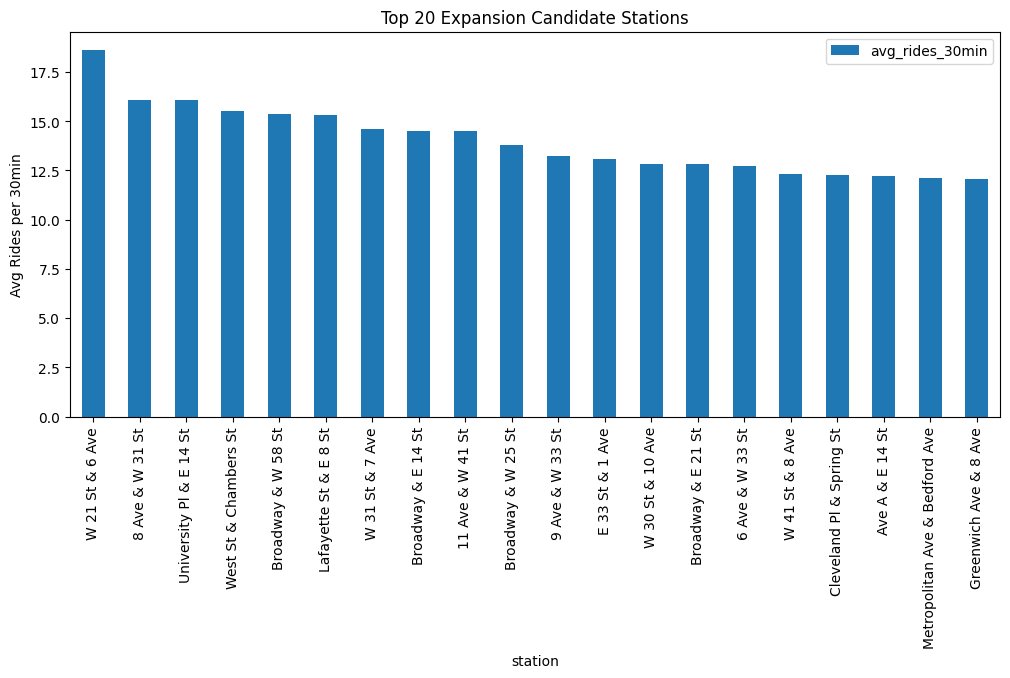

In [45]:
expansion_candidates.plot.bar(x="station", y="avg_rides_30min", figsize=(12,5))
plt.title("Top 20 Expansion Candidate Stations")
plt.ylabel("Avg Rides per 30min")
plt.show()

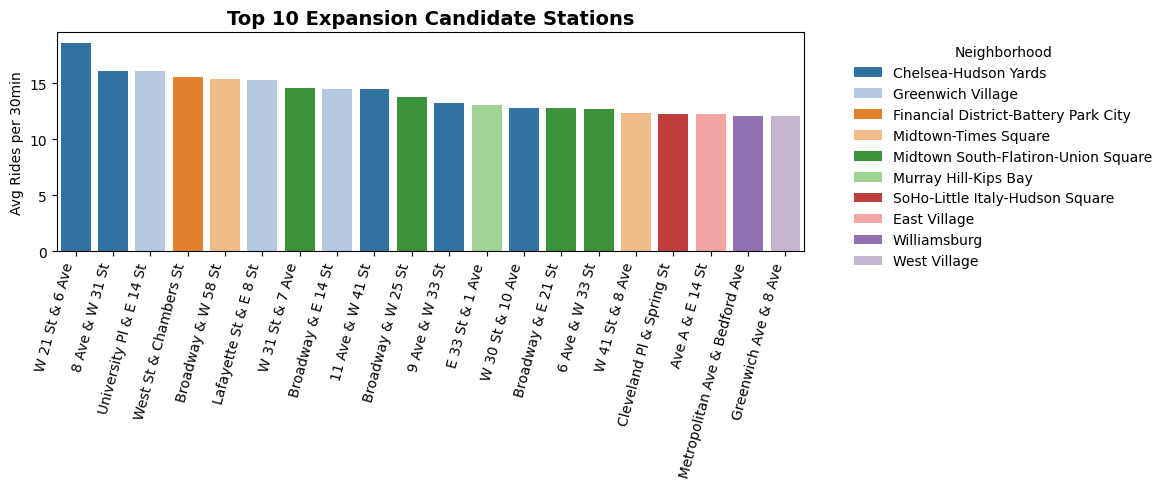

In [46]:
plt.figure(figsize=(12,5))
sns.barplot(
    data=expansion_candidates,
    x="station", 
    y="avg_rides_30min",
    hue="NTAName",             # color by neighborhood
    dodge=False,               # keep one bar per station
    palette="tab20"            # or "Set3", "Paired"
)
plt.title("Top 10 Expansion Candidate Stations", fontsize=14, fontweight="bold")
plt.ylabel("Avg Rides per 30min")
plt.xlabel("")
plt.xticks(rotation=75, ha="right")  # tilt station names
plt.legend(title="Neighborhood", bbox_to_anchor=(1.05,1), loc="upper left", frameon=False)
plt.tight_layout()
plt.show()

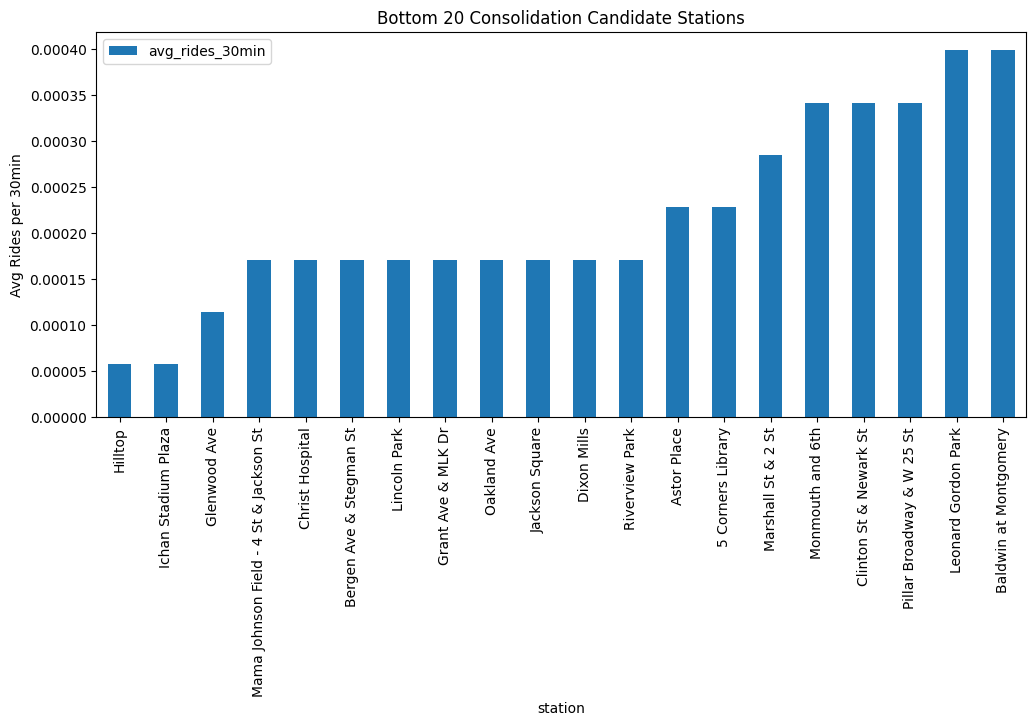

In [47]:
consolidation_candidates.plot.bar(x="station", y="avg_rides_30min", figsize=(12,5))
plt.title("Bottom 20 Consolidation Candidate Stations")
plt.ylabel("Avg Rides per 30min")
plt.show()

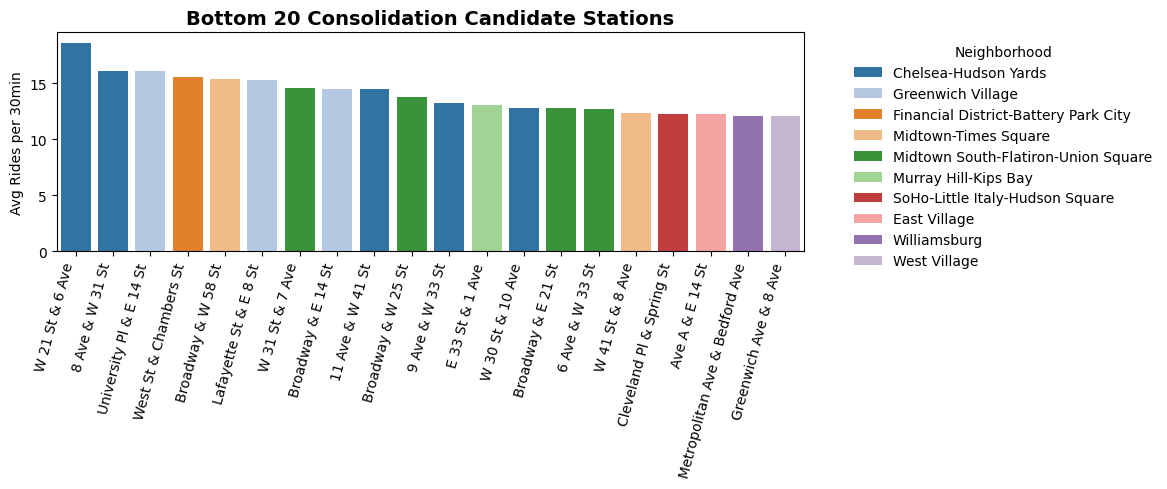

In [48]:
plt.figure(figsize=(12,5))
sns.barplot(
    data=expansion_candidates,
    x="station", 
    y="avg_rides_30min",
    hue="NTAName",
    dodge=False,
    palette="tab20",
    order=expansion_candidates["station"]  # force the same order you already have
)
plt.title("Bottom 20 Consolidation Candidate Stations", fontsize=14, fontweight="bold")
plt.ylabel("Avg Rides per 30min")
plt.xlabel("")
plt.xticks(rotation=75, ha="right")
plt.legend(title="Neighborhood", bbox_to_anchor=(1.05,1), loc="upper left", frameon=False)
plt.tight_layout()
plt.show()


# General Trends and Statistics

In [49]:
#Creating dataframes representing average rides per neighborhood and borough
station_stats_neigh_summary = station_stats.groupby('NTAName')[['avg_rides_30min','variance','total_rides']].mean().sort_values('total_rides', ascending=False).reset_index()
station_stats_boro_summary = station_stats.groupby('BoroName')[['avg_rides_30min','variance','total_rides']].mean().sort_values('total_rides', ascending=False).reset_index()

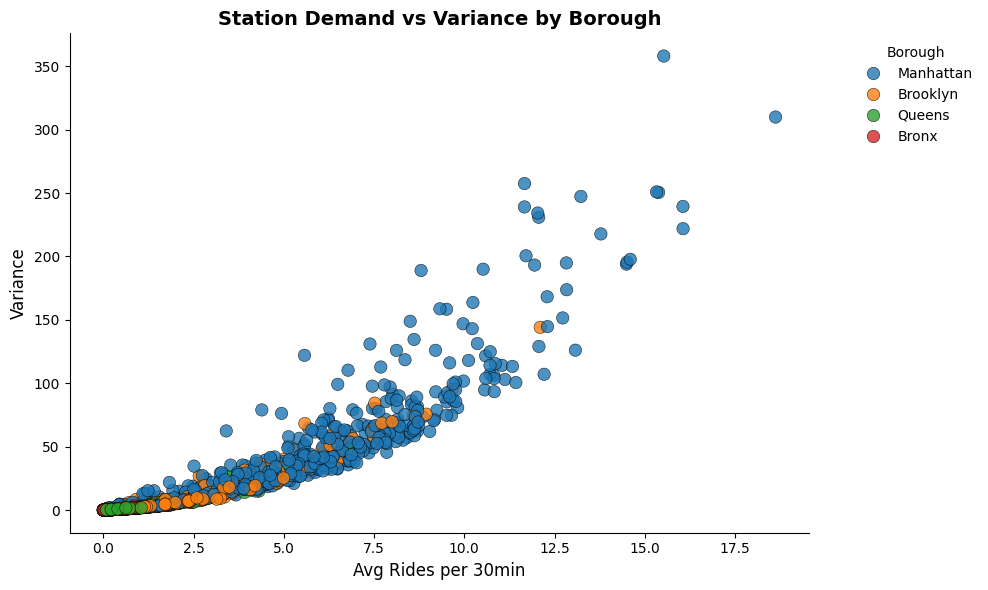

In [50]:
#Plotting Station Demand vs Variance for each borough

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=station_stats,
    x="avg_rides_30min", y="variance",
    hue="BoroName",
    palette="tab10",   
    s=80, alpha=0.8, edgecolor="black", linewidth=0.4
)
plt.title("Station Demand vs Variance by Borough", fontsize=14, fontweight="bold")
plt.xlabel("Avg Rides per 30min", fontsize=12)
plt.ylabel("Variance", fontsize=12)
sns.despine()
plt.legend(title="Borough", bbox_to_anchor=(1.05,1), loc="upper left", frameon=False)
plt.tight_layout()
plt.show()


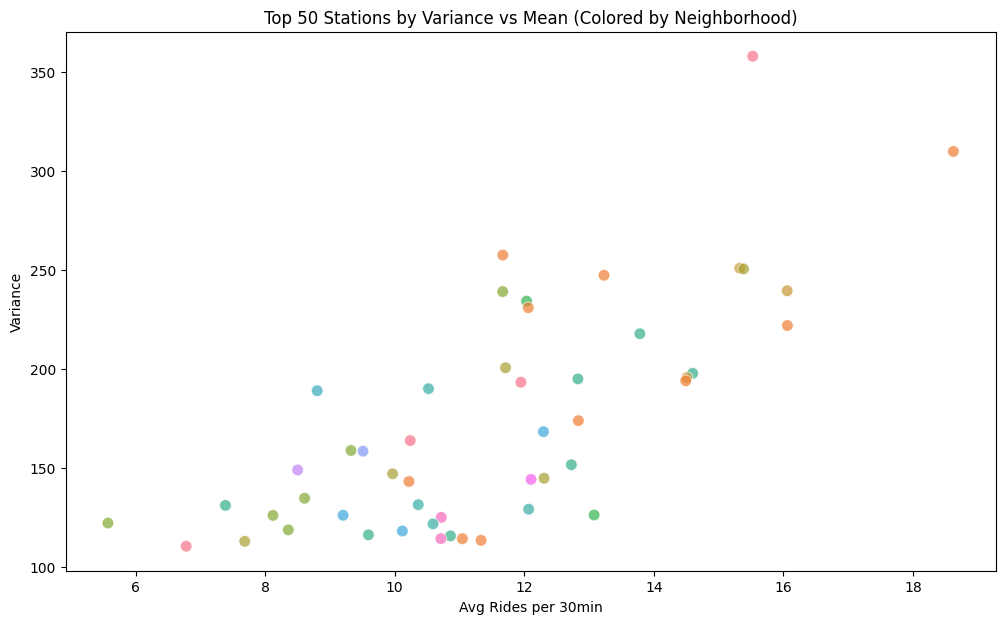

In [51]:
#Plotting variance vs mean for the top 50 stations with highest variance

top_var = station_stats.nlargest(50, "variance")

plt.figure(figsize=(12,7))
sns.scatterplot(
    data=top_var,
    x="avg_rides_30min",
    y="variance",
    hue="NTAName",          # color by neighborhood
    legend=False,           # too many neighborhoods → legend unreadable
    s=70, alpha=0.7
)
plt.title("Top 50 Stations by Variance vs Mean (Colored by Neighborhood)")
plt.xlabel("Avg Rides per 30min")
plt.ylabel("Variance")
plt.show()


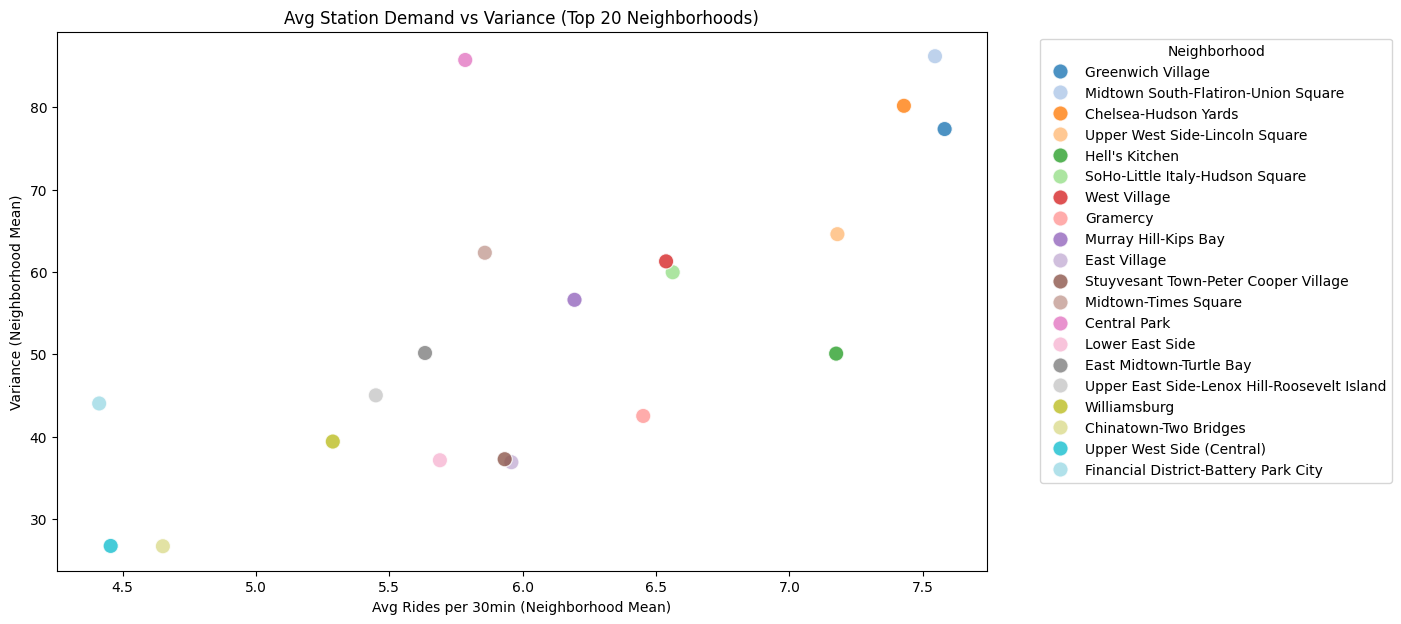

In [52]:
#Plotting the station mean vs variance by the neighborhood

plt.figure(figsize=(12,7))
sns.scatterplot(
    data=station_stats_neigh_summary.head(20),
    x="avg_rides_30min", 
    y="variance",
    hue="NTAName",
    s=120, alpha=0.8, palette="tab20"
)
plt.title("Avg Station Demand vs Variance (Top 20 Neighborhoods)")
plt.xlabel("Avg Rides per 30min (Neighborhood Mean)")
plt.ylabel("Variance (Neighborhood Mean)")
plt.legend(title="Neighborhood", bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()


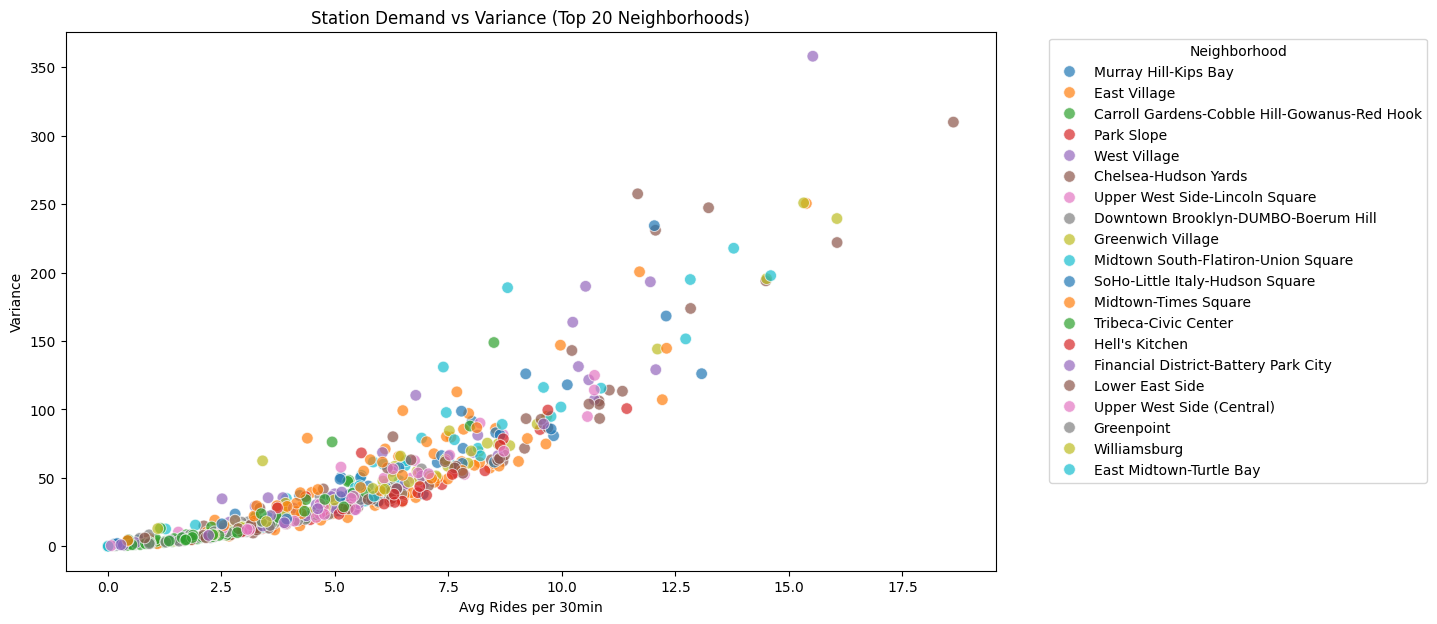

In [53]:
# Rank neighborhoods by total rides

top_neigh = (
    station_stats.groupby("NTAName")["total_rides"]
    .sum()
    .sort_values(ascending=False)
    .head(20)
    .index
)

plot_data = station_stats[station_stats["NTAName"].isin(top_neigh)]

plt.figure(figsize=(12,7))
sns.scatterplot(
    data=plot_data,
    x="avg_rides_30min", y="variance",
    hue="NTAName",
    palette="tab10",    # 10 distinct colors
    s=70, alpha=0.7
)
plt.title("Station Demand vs Variance (Top 20 Neighborhoods)")
plt.xlabel("Avg Rides per 30min")
plt.ylabel("Variance")
plt.legend(title="Neighborhood", bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()


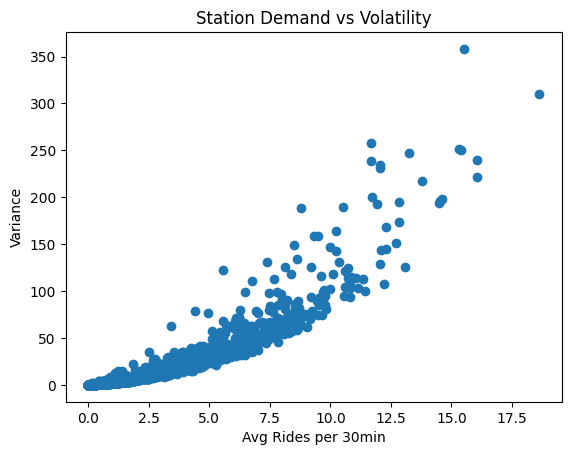

In [54]:
plt.scatter(station_stats["avg_rides_30min"], station_stats["variance"])
plt.xlabel("Avg Rides per 30min")
plt.ylabel("Variance")

plt.title("Station Demand vs Volatility")
plt.show()

In [55]:
print(consolidation_candidates)

                                     station  avg_rides_30min  variance  \
1382                                 Hilltop         0.000057  0.000057   
1400                     Ichan Stadium Plaza         0.000057  0.000057   
1287                            Glenwood Ave         0.000114  0.000114   
1569  Mama Johnson Field - 4 St & Jackson St         0.000171  0.000285   
808                          Christ Hospital         0.000171  0.000171   
621                  Bergen Ave & Stegman St         0.000171  0.000171   
1522                            Lincoln Park         0.000171  0.000171   
1331                      Grant Ave & MLK Dr         0.000171  0.000285   
1699                             Oakland Ave         0.000171  0.000171   
1419                          Jackson Square         0.000171  0.000171   
945                              Dixon Mills         0.000171  0.000171   
1830                          Riverview Park         0.000171  0.000171   
572                      

In [56]:
#Adding weather features and dates into total traffic

final_total_traffic = pd.concat(
    [total_traffic_df, weather_df, dates_df, days_dates_df, season_col],
    axis=1
)

In [57]:
final_total_traffic.head()

1 Ave & E 110 St  1 Ave & E 118 St  1 Ave & E 16 St  \
2024-01-01 00:00:00               0.0               0.0              0.0   
2024-01-01 00:30:00               2.0               0.0              5.0   
2024-01-01 01:00:00               1.0               0.0              4.0   
2024-01-01 01:30:00               0.0               0.0              4.0   
2024-01-01 02:00:00               0.0               0.0              3.0   

                     1 Ave & E 18 St  1 Ave & E 30 St  1 Ave & E 38 St  \
2024-01-01 00:00:00              0.0              5.0              0.0   
2024-01-01 00:30:00              3.0              2.0              0.0   
2024-01-01 01:00:00              3.0              2.0              0.0   
2024-01-01 01:30:00              0.0              2.0              0.0   
2024-01-01 02:00:00              3.0              4.0              0.0   

                     1 Ave & E 39 St  1 Ave & E 42 St  1 Ave & E 44 St  \
2024-01-01 00:00:00              2.0              0.0              0.0   
2024-01-01 00:30:00              5.0              0.0              1.0   
2024-01-01 01:00:00              5.0              0.0              2.0   
2024-01-01 01:30:00              0.0              0.0              2.0   
2024-01-01 02:00:00              3.0              0.0              0.0   

                     1 Ave & E 6 St  ...  York St & Marin Blvd  precip_mm  \
2024-01-01 00:00:00             5.0  ...                   0.0        0.0   
2024-01-01 00:30:00             7.0  ...                   0.0        0.0   
2024-01-01 01:00:00             9.0  ...                   0.0        0.0   
2024-01-01 01:30:00             2.0  ...                   0.0        0.0   
2024-01-01 02:00:00             4.0  ...                   0.0        0.0   

                     wind_speed  is_raining  temp_f  holidays  is_weekend  \
2024-01-01 00:00:00        11.0           0    42.8      True       False   
2024-01-01 00:30:00        11.0           0    42.8      True       False   
2024-01-01 01:00:00         7.9           0    42.8      True       False   
2024-01-01 01:30:00         7.9           0    42.8      True       False   
2024-01-01 02:00:00         6.0           0    42.8      True       False   

                     day of week  month  season  
2024-01-01 00:00:00            0      1  Winter  
2024-01-01 00:30:00            0      1  Winter  
2024-01-01 01:00:00            0      1  Winter  
2024-01-01 01:30:00            0      1  Winter  
2024-01-01 02:00:00            0      1  Winter  

[5 rows x 2302 columns]

In [58]:
#Creating dataframes that represent total rides per week and per month

total_traffic_df['total rides'] = total_traffic_df.sum(axis=1)

monthly_demand = (
    total_traffic_df['total rides']
    .resample('M')
    .sum()
    .reset_index()
)

weekly_demand = (
    total_traffic_df['total rides']
    .resample('W')
    .sum()
    .reset_index
)

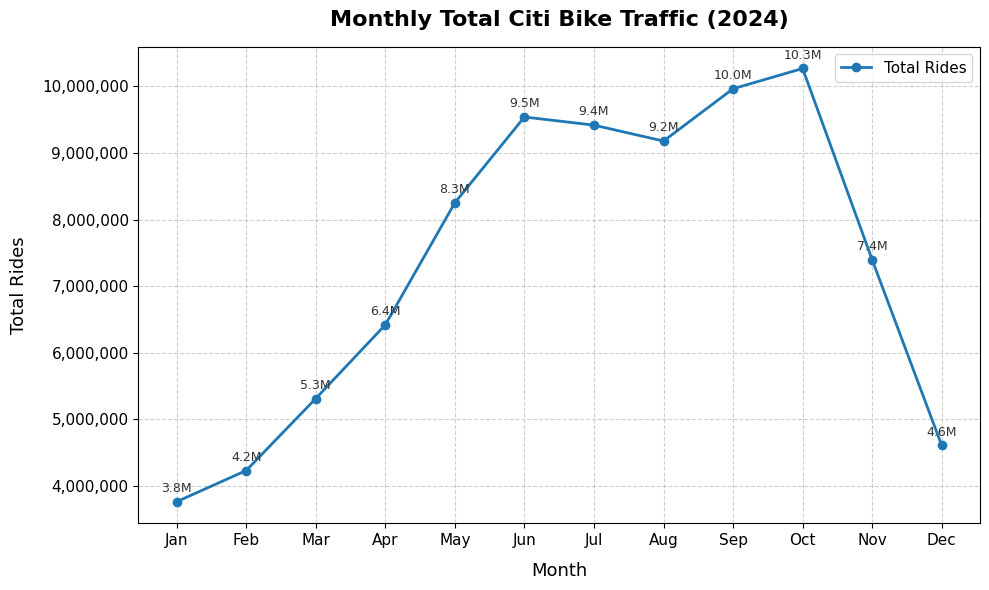

In [61]:
import matplotlib.ticker as mtick

plt.figure(figsize=(10,6))
plt.plot(
    monthly_demand['total rides'], 
    marker="o", 
    linestyle="-", 
    linewidth=2, 
    markersize=6, 
    color="#1f77b4", 
    label="Total Rides"
)


plt.title("Monthly Total Citi Bike Traffic (2024)", fontsize=16, weight="bold", pad=15)
plt.xlabel("Month", fontsize=13, labelpad=10)
plt.ylabel("Total Rides", fontsize=13, labelpad=10)


months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
plt.xticks(ticks=range(len(months)), labels=months, fontsize=11)


plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))


plt.grid(True, linestyle="--", alpha=0.6)
plt.yticks(fontsize=11)


for i, val in enumerate(monthly_demand['total rides']):
    plt.text(i, val+100000, f"{val/1e6:.1f}M", ha="center", va="bottom", fontsize=9, color="#333")


plt.legend(fontsize=11)

plt.tight_layout()
plt.show()


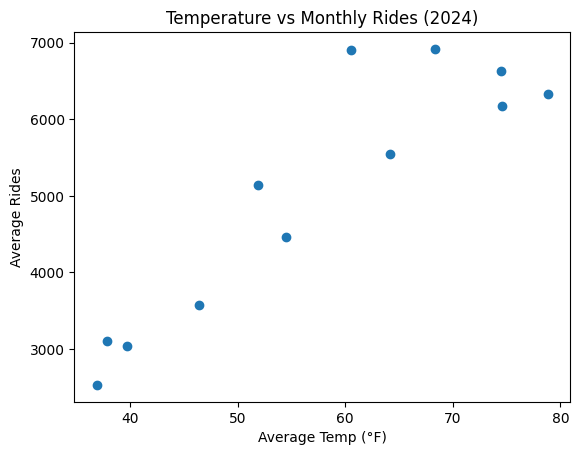

In [62]:
BASE_COLS = [
    "is_raining",
    "temp_f",
    "precip_mm",
    "wind_speed",
    "holidays",
    "is_weekend",
    "day of week",
    "month",
    "season"
]

final_total_traffic['total rides'] = final_total_traffic[[col for col in final_total_traffic.columns if col not in BASE_COLS]].sum(axis=1)

weather_corr = final_total_traffic[["total rides", "temp_f", "is_raining"]].copy()

# Monthly averages for smoother view
weather_monthly = weather_corr.resample("M").mean()

plt.scatter(weather_monthly["temp_f"], weather_monthly["total rides"])
plt.title("Temperature vs Monthly Rides (2024)")
plt.xlabel("Average Temp (°F)")
plt.ylabel("Average Rides")
plt.show()

# Heatmaps

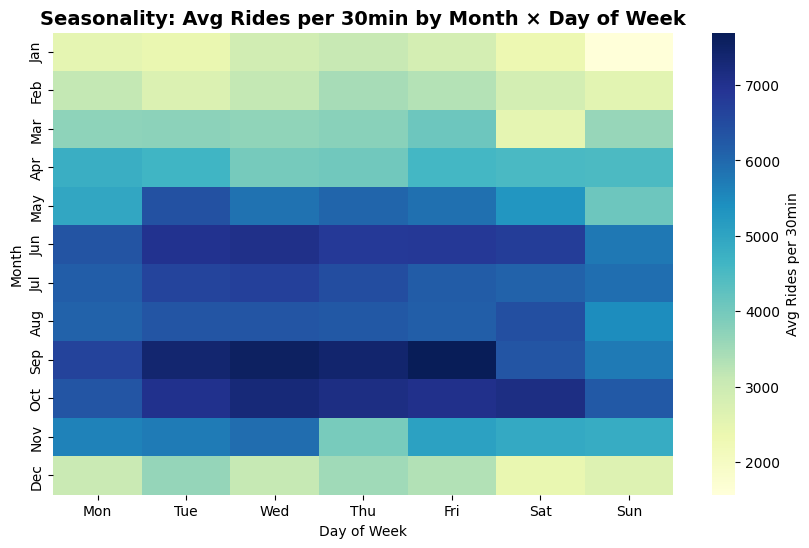

In [63]:
#Heatmap the shows which days and which months have the most traffic

heatmap_df = total_traffic_df.copy()
heatmap_df["month"] = heatmap_df.index.month
heatmap_df["day_of_week"] = heatmap_df.index.dayofweek

# Map days and months to names
day_map = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
             7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

heatmap_df["day_name"] = heatmap_df["day_of_week"].map(day_map)
heatmap_df["month_name"] = heatmap_df["month"].map(month_map)

heatmap_group = (
    heatmap_df.groupby(["month_name","day_name"])["total rides"]
    .mean()
    .unstack()
    .reindex(index=list(month_map.values()), columns=list(day_map.values()))
)

plt.figure(figsize=(10,6))
sns.heatmap(heatmap_group, cmap="YlGnBu", annot=False, cbar_kws={'label': 'Avg Rides per 30min'})
plt.title("Seasonality: Avg Rides per 30min by Month × Day of Week", fontsize=14, fontweight="bold")
plt.xlabel("Day of Week")
plt.ylabel("Month")
plt.show()

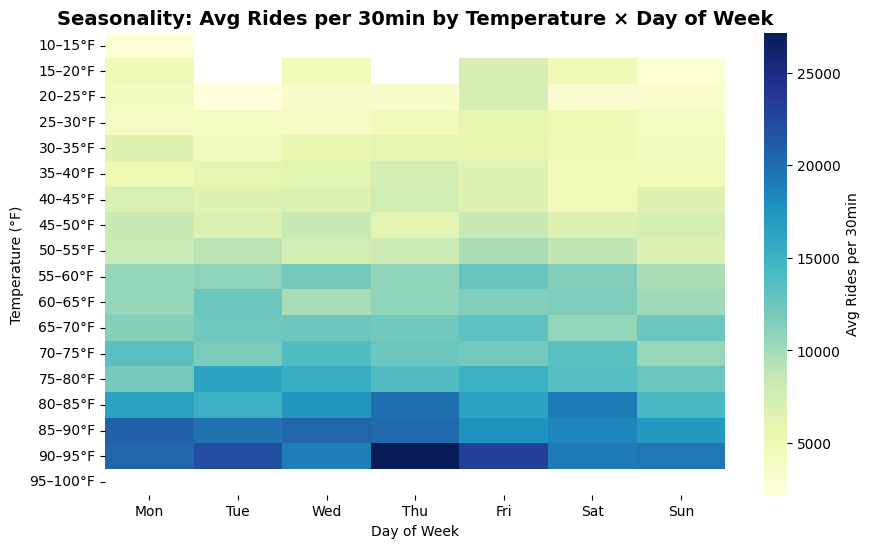

In [64]:
# Creating Heatmap of Day of Week vs Temperature

heatmap_df_temp = final_total_traffic.copy()
heatmap_df_temp = heatmap_df_temp[[col for col in heatmap_df_temp.columns if col not in BASE_COLS or col == 'temp_f']]

heatmap_df_temp['day'] = total_traffic_df.index.dayofweek
heatmap_df_temp['total_rides'] = heatmap_df_temp[[col for col in heatmap_df_temp.columns if col != 'day' and col != 'temp_f']].sum(axis=1)

# Temp bins with labels
bins = np.arange(10, 105, 5)
labels = [f"{low}–{high}°F" for low, high in zip(bins[:-1], bins[1:])]
heatmap_df_temp['temp_bin'] = pd.cut(
    heatmap_df_temp['temp_f'], 
    bins=bins,  
    labels=labels,
    right=False,
    include_lowest=True,
    ordered=True
)

# Map day numbers to names
day_map = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
heatmap_df_temp['day_name'] = heatmap_df_temp['day'].map(day_map)

heatmap_df_group = (
    heatmap_df_temp.groupby(['temp_bin','day_name'])['total_rides']
    .mean()
    .unstack()
    .reindex(columns=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']) 
    .reindex(index=labels)  
)

plt.figure(figsize=(10,6))
sns.heatmap(heatmap_df_group, cmap="YlGnBu", annot=False, cbar_kws={'label': 'Avg Rides per 30min'})
plt.title("Seasonality: Avg Rides per 30min by Temperature × Day of Week", fontsize=14, fontweight="bold")
plt.xlabel("Day of Week")
plt.ylabel("Temperature (°F)")
plt.show()


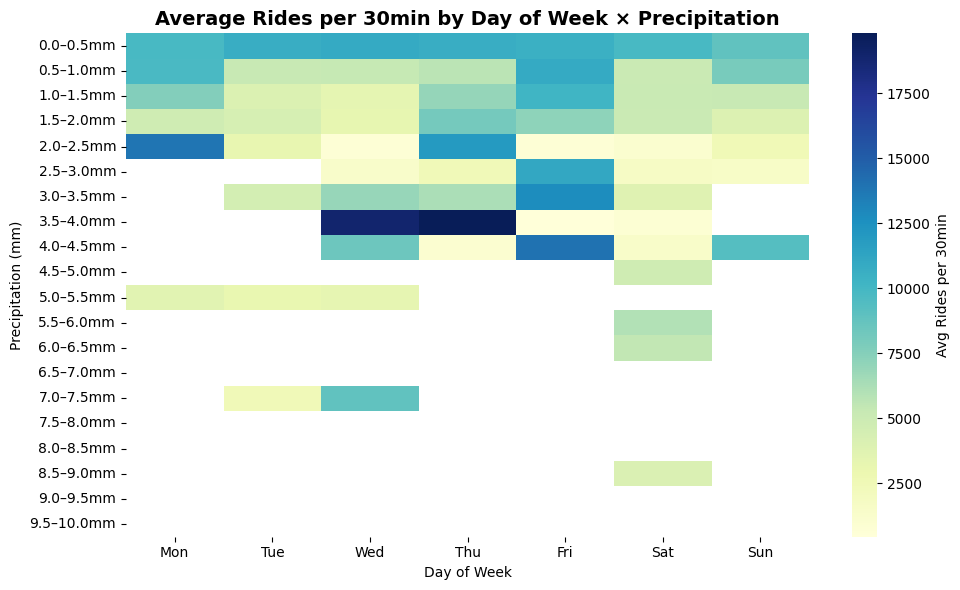

In [65]:
# Creating a heatmap of total rides for day of week vs precipitation

heatmap_df_rain_day = final_total_traffic.copy()
heatmap_df_rain_day = heatmap_df_rain_day[[col for col in heatmap_df_rain_day.columns if col not in BASE_COLS or col == 'precip_mm']]

# Add day of week (0=Mon, 6=Sun)
heatmap_df_rain_day['day'] = heatmap_df_rain_day.index.dayofweek
day_map = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
heatmap_df_rain_day['day_name'] = heatmap_df_rain_day['day'].map(day_map)

# Compute total rides per timestamp
heatmap_df_rain_day['total_rides'] = heatmap_df_rain_day[
    [col for col in heatmap_df_rain_day.columns if col not in ['precip_mm','day','day_name']]
].sum(axis=1)

# --- Precipitation bins with labels ---
precip_bins = np.arange(0, 10.5, 0.5)  
precip_labels = [f"{a:.1f}–{b:.1f}mm" for a, b in zip(precip_bins[:-1], precip_bins[1:])]

heatmap_df_rain_day['precip_bin'] = pd.cut(
    heatmap_df_rain_day['precip_mm'], 
    bins=precip_bins, 
    labels=precip_labels,
    include_lowest=True,
    right=False,
    ordered=True
)

# Group and pivot
heatmap_df_group = (
    heatmap_df_rain_day
    .groupby(['precip_bin','day_name'])['total_rides']
    .mean()
    .unstack()
    .reindex(index=precip_labels, columns=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
)

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(heatmap_df_group, cmap="YlGnBu", cbar_kws={'label': 'Avg Rides per 30min'})
plt.title("Average Rides per 30min by Day of Week × Precipitation", fontsize=14, fontweight="bold")
plt.xlabel("Day of Week")
plt.ylabel("Precipitation (mm)")
plt.tight_layout()
plt.show()


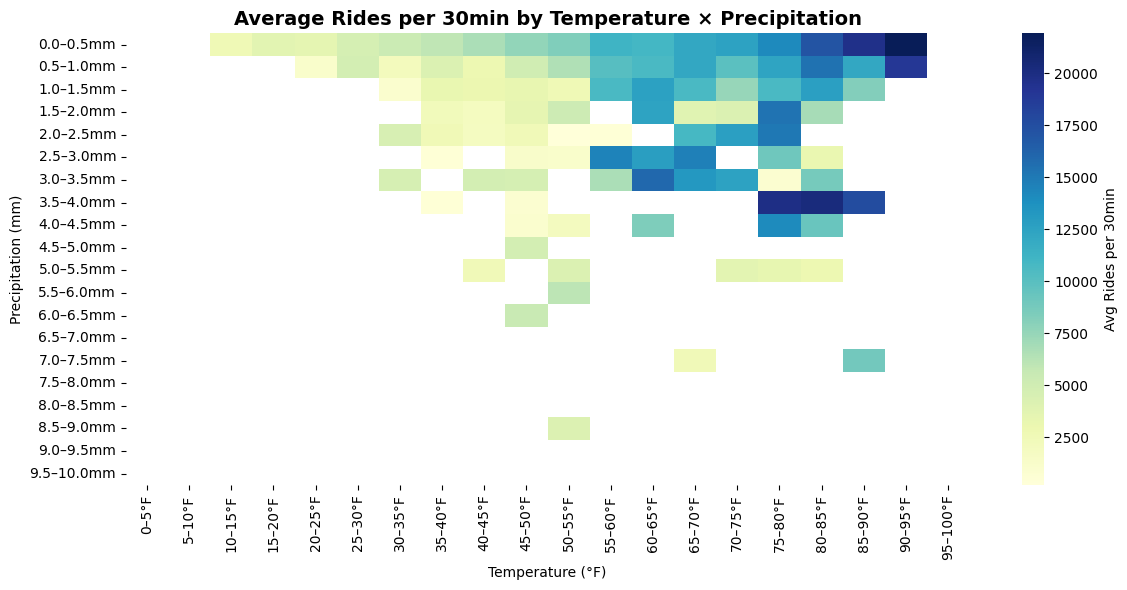

In [66]:
# Creating a heatmap of total rides for temperature vs the amount it rains

heatmap_df_rain = final_total_traffic.copy()
heatmap_df_rain = heatmap_df_rain[[col for col in heatmap_df_rain.columns if col not in BASE_COLS or col in ['temp_f', 'precip_mm']]]
heatmap_df_rain['total_rides'] = heatmap_df_rain[[col for col in heatmap_df_rain.columns if col != 'temp_f' and col != 'precip_mm']].sum(axis=1)

# --- Temperature bins with labels ---
bins = np.arange(0, 105, 5)
labels = [f"{low}–{high}°F" for low, high in zip(bins[:-1], bins[1:])]

heatmap_df_rain["temp_bin"] = pd.cut(
    heatmap_df_rain["temp_f"], 
    bins=bins, 
    labels=labels,  
    include_lowest=True,
    right=False,
    ordered=True
)

precip_bins = np.arange(0, 10.5, 0.5)  
precip_labels = [f"{a:.1f}–{b:.1f}mm" for a, b in zip(precip_bins[:-1], precip_bins[1:])]

heatmap_df_rain['precip_bin'] = pd.cut(
    heatmap_df_rain['precip_mm'], 
    bins=precip_bins, 
    labels=precip_labels,
    include_lowest=True,
    right=False,
    ordered=True
)

heatmap_df_group = (
    heatmap_df_rain
    .groupby(['precip_bin','temp_bin'])['total_rides']
    .mean()
    .unstack()
    .reindex(index=precip_labels, columns=labels)
)

plt.figure(figsize=(12,6))
sns.heatmap(heatmap_df_group, cmap="YlGnBu", cbar_kws={'label': 'Avg Rides per 30min'})
plt.title("Average Rides per 30min by Temperature × Precipitation", fontsize=14, fontweight="bold")
plt.xlabel("Temperature (°F)")
plt.ylabel("Precipitation (mm)")
plt.tight_layout()
plt.show()


# Further Exploratory Analysis

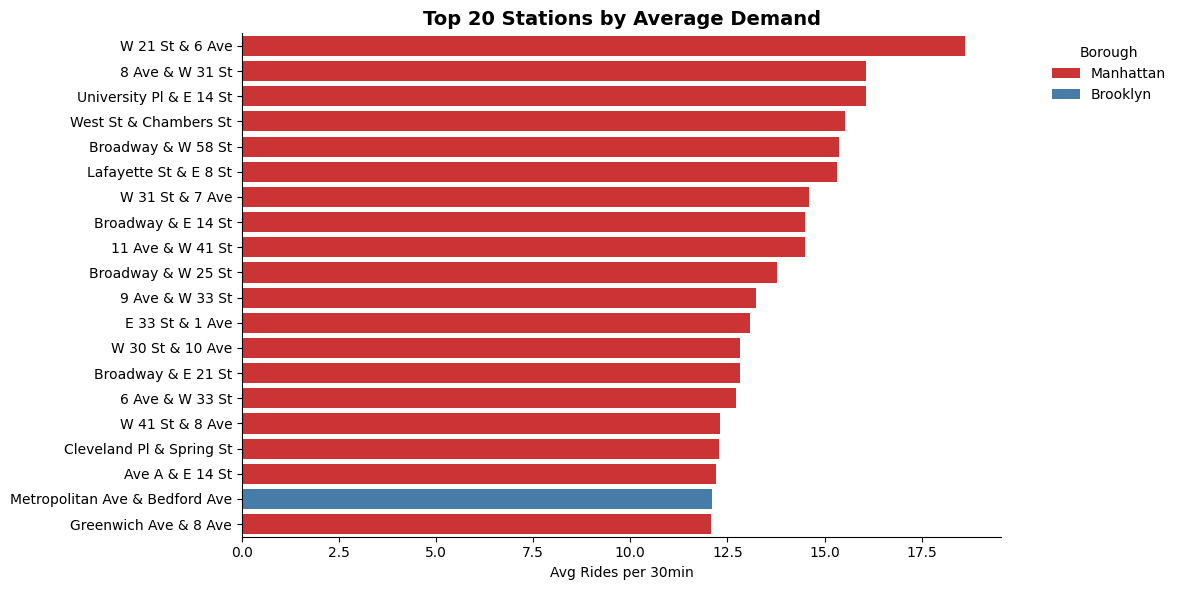

In [67]:
# Top 20 busiest stations by avg demand
top20 = station_stats.nlargest(20, "avg_rides_30min")

plt.figure(figsize=(12,6))
sns.barplot(
    data=top20,
    x="avg_rides_30min",
    y="station",
    hue="BoroName",          
    dodge=False,             
    palette="Set1"
)
plt.title("Top 20 Stations by Average Demand", fontsize=14, fontweight="bold")
plt.xlabel("Avg Rides per 30min")
plt.ylabel("")
plt.legend(title="Borough", bbox_to_anchor=(1.05,1), loc="upper left", frameon=False)
sns.despine()
plt.tight_layout()
plt.show()


In [68]:
top20.head()

station  avg_rides_30min    variance  total_rides  \
2099          W 21 St & 6 Ave        18.623577  309.952850     327179.0   
467           8 Ave & W 31 St        16.061418  221.938107     282167.0   
2014  University Pl & E 14 St        16.058345  239.463949     282113.0   
2241    West St & Chambers St        15.527038  358.100026     272779.0   
704        Broadway & W 58 St        15.385018  250.523011     270284.0   

                                   NTAName   BoroName  
2099                  Chelsea-Hudson Yards  Manhattan  
467                   Chelsea-Hudson Yards  Manhattan  
2014                     Greenwich Village  Manhattan  
2241  Financial District-Battery Park City  Manhattan  
704                   Midtown-Times Square  Manhattan

In [69]:
top20.head(20)

station  avg_rides_30min    variance  \
2099                 W 21 St & 6 Ave        18.623577  309.952850   
467                  8 Ave & W 31 St        16.061418  221.938107   
2014         University Pl & E 14 St        16.058345  239.463949   
2241           West St & Chambers St        15.527038  358.100026   
704               Broadway & W 58 St        15.385018  250.523011   
1477           Lafayette St & E 8 St        15.326218  250.912930   
2119                 W 31 St & 7 Ave        14.599898  197.749569   
666               Broadway & E 14 St        14.509847  195.529589   
40                  11 Ave & W 41 St        14.492828  193.969437   
694               Broadway & W 25 St        13.784324  217.777982   
490                  9 Ave & W 33 St        13.230931  247.341385   
1089                 E 33 St & 1 Ave        13.078552  126.073752   
2117                W 30 St & 10 Ave        12.835496  173.775066   
668               Broadway & E 21 St        12.828723  194.912713   
384                  6 Ave & W 33 St        12.726833  151.516598   
2133                 W 41 St & 8 Ave        12.305840  144.670104   
831         Cleveland Pl & Spring St        12.296334  168.229822   
580                  Ave A & E 14 St        12.212204  107.074225   
1610  Metropolitan Ave & Bedford Ave        12.104793  144.111805   
1343           Greenwich Ave & 8 Ave        12.068249  129.021527   

      total_rides                               NTAName   BoroName  
2099     327179.0                  Chelsea-Hudson Yards  Manhattan  
467      282167.0                  Chelsea-Hudson Yards  Manhattan  
2014     282113.0                     Greenwich Village  Manhattan  
2241     272779.0  Financial District-Battery Park City  Manhattan  
704      270284.0                  Midtown-Times Square  Manhattan  
1477     269251.0                     Greenwich Village  Manhattan  
2119     256491.0   Midtown South-Flatiron-Union Square  Manhattan  
666      254909.0                     Greenwich Village  Manhattan  
40       254610.0                  Chelsea-Hudson Yards  Manhattan  
694      242163.0   Midtown South-Flatiron-Union Square  Manhattan  
490      232441.0                  Chelsea-Hudson Yards  Manhattan  
1089     229764.0                  Murray Hill-Kips Bay  Manhattan  
2117     225494.0                  Chelsea-Hudson Yards  Manhattan  
668      225375.0   Midtown South-Flatiron-Union Square  Manhattan  
384      223585.0   Midtown South-Flatiron-Union Square  Manhattan  
2133     216189.0                  Midtown-Times Square  Manhattan  
831      216022.0       SoHo-Little Italy-Hudson Square  Manhattan  
580      214544.0                          East Village  Manhattan  
1610     212657.0                          Williamsburg   Brooklyn  
1343     212015.0                          West Village  Manhattan

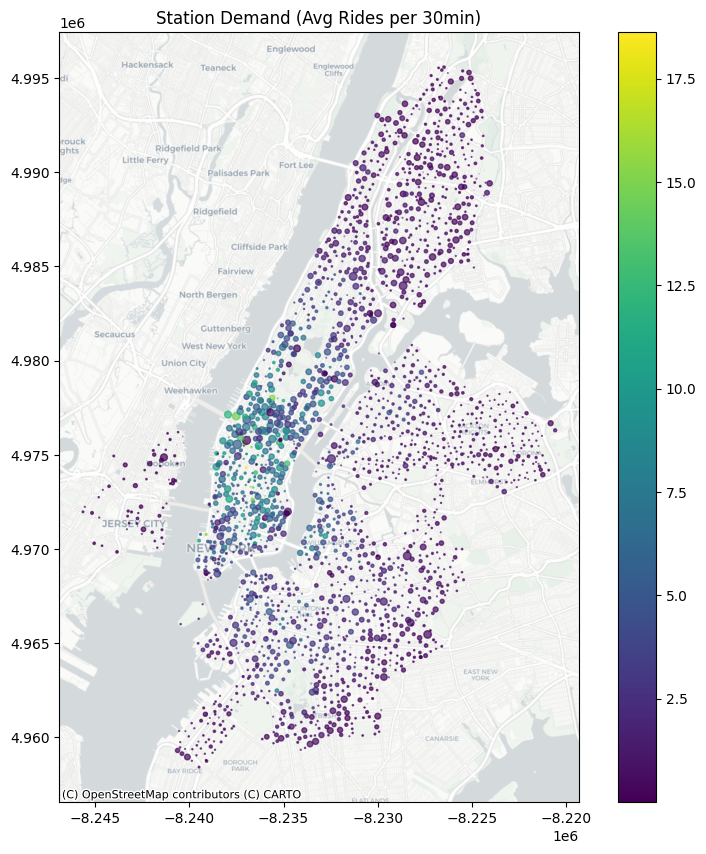

In [70]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.geometry import Point
stations_with_demand = station_stats.merge(stations_cord_df, how='left', on='station')

# Build GeoDataFrame
gdf = gpd.GeoDataFrame(
    stations_with_demand,
    geometry=gpd.points_from_xy(stations_with_demand["lon"], stations_with_demand["lat"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)  # project to Web Mercator

# Plot with basemap
fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(
    ax=ax,
    column="avg_rides_30min",
    cmap="viridis",
    markersize=gdf["avg_rides_30min"]*2,
    alpha=0.7,
    legend=True
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
plt.title("Station Demand (Avg Rides per 30min)")
plt.show()


In [72]:
import folium
import branca.colormap as cm
from IPython.display import IFrame

stations_clean = stations_with_demand.dropna(subset=["lat", "lon"])

m = folium.Map(location=[40.73, -73.94], zoom_start=12, tiles="CartoDB positron")

# Continuous Viridis colormap
colormap = cm.linear.viridis.scale(
    stations_clean["avg_rides_30min"].min(),
    stations_clean["avg_rides_30min"].max()
)

for _, row in stations_clean.iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=row["avg_rides_30min"] / 5,
        fill=True,
        fill_opacity=0.6,
        color=colormap(row["avg_rides_30min"]),
        fill_color=colormap(row["avg_rides_30min"]),
        popup=f"{row['station']}: {row['avg_rides_30min']:.1f} rides"
    ).add_to(m)

colormap.caption = "Avg Rides per 30min"
colormap.add_to(m)

m.save("station_demand_map.html")
IFrame("station_demand_map.html", width=800, height=600)
m


In [73]:

# Define window
event_date = "2024-11-08"
start_time = f"{event_date} 18:00:00"
end_time   = f"{event_date} 19:30:00"

# Filter arrivals within window and sum across time
event_arrivals = df_enter_final.loc[start_time:end_time].sum(axis=0).reset_index()
event_arrivals.columns = ["station", "rides"]


In [74]:
event_station_counts = event_arrivals.merge(stations_cord_df, on="station", how="left")

In [75]:
import plotly.express as px

fig = px.density_mapbox(
    event_station_counts,
    lat="lat", lon="lon", z="rides",
    radius=15,
    center={"lat": 40.7505, "lon": -73.9934},  # MSG
    zoom=13,
    mapbox_style="carto-positron",
    title="Citi Bike Heatmap — Pre-Knicks Game (Nov 8, 2024, 6–7:30PM)"
)
fig.show()


In [76]:

# # Define window
# event_date_2 = "2024-10-22"
# start_time_2 = f"{event_date_2} 18:00:00"
# end_time_2   = f"{event_date_2} 19:30:00"

# # Filter arrivals within window and sum across time
# event_arrivals_2 = df_enter_final.loc[start_time_2:end_time_2].sum(axis=0).reset_index()
# event_arrivals_2.columns = ["station", "rides"]


In [77]:
# event_station_counts_2 = event_arrivals_2.merge(stations_cord_df, on="station", how="left")


In [78]:
# fig_2 = px.density_mapbox(
#     event_station_counts_2,
#     lat="lat", lon="lon", z="rides",
#     radius=15,
#     center={"lat": 40.7505, "lon": -73.9934},  # MSG
#     zoom=13,
#     mapbox_style="carto-positron",
#     title="Citi Bike Heatmap — Pre-Knicks Game (Nov 8, 2024, 6–7:30PM)"
# )
# fig_2.show()

In [ ]:
# import geopandas as gpd
# import matplotlib.pyplot as plt

# # 1. Load NTA GeoJSON (make sure this file exists in your folder)
# nta = gpd.read_file("Neighborhood_NTA.geojson")

# # 2. Build GeoDataFrame for your stations
# stations_gdf = gpd.GeoDataFrame(
#     station_stats,
#     geometry=gpd.points_from_xy(station_stats["lon"], station_stats["lat"]),
#     crs="EPSG:4326"
# )

# # 3. Match CRS
# nta = nta.to_crs(stations_gdf.crs)

# # 4. Spatial join (add NTAName to each station)
# stations_with_nta = gpd.sjoin(
#     stations_gdf,
#     nta[["NTA2020", "NTAName", "geometry"]],
#     how="left",
#     predicate="within"
# )

# # 5. Quick visualization: stations on NTA map
# fig, ax = plt.subplots(figsize=(12,12))
# nta.boundary.plot(ax=ax, linewidth=0.5, color="black")
# stations_with_nta.plot(
#     ax=ax,
#     column="avg_rides_30min",   # color stations by avg demand
#     cmap="viridis",
#     markersize=stations_with_nta["avg_rides_30min"] / 5,
#     alpha=0.7,
#     legend=True
# )
# plt.title("Citi Bike Station Demand Across NYC Neighborhoods", fontsize=16, fontweight="bold")
# plt.show()
